# Proyecto 3 de Bioseñales y sistemas


**Inicialmente se deben importar las librerias con las que se ejecutaron todos los códigos, las cuales son: numpy, scipy, matplotlib, glob y pandas. También se cargan a este archivo los datos con los cuales se trabajó, que corresponden a 36 pacientes de control y 23 pacientes de parkinson.**

In [ ]:
 # Se importan las librerias
import numpy as np;
import matplotlib.pyplot as plt
import glob
from google.colab import drive
drive.mount('/content/drive')
import scipy.io as sio;
from scipy.signal import welch as pwelch
import pandas as pd

# Se importan los archivos
archivos_g1 = glob.glob('/content/drive/Shareddrives/biosenales_sistemas/datasets_proyecto1/control/*.mat')
/content/drive/Shareddrives/biosenales_sistemas/datasets_proyecto1/control
/content/drive/Shareddrives/biosenales_sistemas/datasets_proyecto1/control/C001R_EP_reposo.mat
archivos_g2 = glob.glob('/content/drive/Shareddrives/biosenales_sistemas/datasets_proyecto1/parkinson/*.mat')
print('Hay ' + str(len(archivos_g1)) + ' sujetos de control')     # Hay 36 sujetos de control
print('Hay ' + str(len(archivos_g2)) + ' sujetos de parkinson')     # Hay 23 sujetos de parkinson

# Los siguientes archivos se usaron para probar el funcionamiento de los códigos, para dar los ejemplos
archivo1 = sio.loadmat(archivos_g1[1])    # Este es un diccionario con los datos que representa a un paciente particular
archivo2 = sio.loadmat(archivos_g2[1])
control1 = archivo1['data']       # Estos son los datos guardados en la clave 'data', que corresponden a una matriz 3D
parkinson1 = archivo2['data']
print(control1.shape)


Mounted at /content/drive
Hay 36 sujetos de control
Hay 23 sujetos de parkinson
(8, 2000, 176)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Calcular la fft para cada epoca, sumarlas para cada canal y sacar el promedio en potencias y mostrarlo en frecuencia para un canal, lo mismo para parkinson y graficar

**1. Crear una función que reciba una señal de EEG y permita calcular la parte imaginaria de la coherencia**

La parte imaginaria de la coherencia se calcula con la siguiente ecuación:

$$IC_{xy}(f)=\frac{Im(S_{xy}(f))}{\sqrt{S_{xx}(f)S_{yy}(f)}}$$

En donde X y Y son señales.

Sx y Sy son las transformadas discretas de fourier.

Sxx y Syy es el producto de cada una de sus DFT consigo misma, es decir,  Sx * Sx  y  Sy * Sy

y Sxy es el producto de las transformadas cruzadas, es decir,  Sx * Sy.

In [ ]:
def Imag_coher(x,y):
  '''
  Esta función recibe dos vectores y retorna un vector
  '''
  sx = np.fft.fft(x)    # Tansformada de Fourier del primer vector
  sy = np.fft.fft(y)    # Tansformada de Fourier del segundo vector
  sxy = sx*sy     # Densidad espectral cruzada
  sxx = sx*sx     # Densidad espectral de sx
  syy = sy*sy     # Densidad espectral de sy
  part_i = sxy.imag     # Parte imaginaria de la densidad espectral cruzada
  part_r = np.sqrt(sxx*syy).real    # Parte real y raiz cuadrada
  ICxy = part_i/part_r      # Parte imaginaria de la coherencia
  return ICxy
a=Imag_coher(control1[1,:,73],control1[1,:,73])


**2. Crear una función que reciba una señal EEG de múltiples canales y calcule la potencia relativa, estimada con una potencia máxima de 40Hz, en las bandas de interés IPEG 2012 para cada canal. Con las potencias relativas
obtenidas retornar la relación entre (alfa1 + alfa2)/theta.**

In [ ]:
# La siguiente función calcula la potencia relativa y la relación pedida de un señal genérica
def potencia_relativa(senal):
  '''
  Esta función recibe un vector y retorna una lista con dos elementos: un array y un flotante
  '''
  num_puntos_por_segundo = 250; # Preguntar si cambia
  nperseg = 2000
  noverlap = int(nperseg/2);
  f, Pxx = pwelch(senal, num_puntos_por_segundo, 'hanning', nperseg, noverlap);
  #se extrae la potencia de cada banda
  delta = np.sum(Pxx[(f >= 1.5) & (f < 6)]);
  theta = np.sum(Pxx[(f >= 6) & (f < 8.5)]);
  alfa1 = np.sum(Pxx[(f >= 8.5) & (f < 10.5)]);
  alfa2 = np.sum(Pxx[(f >= 10.5) & (f < 12.5)]);
  beta1 = np.sum(Pxx[(f >= 12.5) & (f < 18.5)]);
  beta2 = np.sum(Pxx[(f >= 18.5) & (f < 21)]);
  beta3 = np.sum(Pxx[(f >= 21) & (f < 30)]);
  gamma = np.sum(Pxx[(f >= 30) & (f < 40)]);
  #se extrae la potencia total
  total = np.sum(Pxx[f <= 40]);
  #se extrae la potencia relativa
  delta_relativo = delta/total;
  theta_relativo = theta/total;
  alfa1_relativo = alfa1/total;
  alfa2_relativo = alfa2/total;
  beta1_relativo = beta1/total;
  beta2_relativo = beta2/total;
  beta3_relativo = beta3/total;
  gamma_relativo = gamma/total;
  #convertimos una lista en python a un ndarray de numpy
  potencia = np.asarray([delta_relativo, theta_relativo, alfa1_relativo, alfa2_relativo, beta1_relativo,
                          beta2_relativo, beta3_relativo, gamma_relativo,]);
  relacion = (alfa1_relativo + alfa2_relativo)/theta_relativo
  salida = [potencia, relacion]
  print(salida) # Borrar esta linea al final para entregar el codigo organizado
  return salida

# La siguiente función recorre los canales de un EEG de varios canales, es decir una el EEG de 1 paciente
def potencia_de_EEG(EEG):
  '''
  Esta función recibe una matriz 3D y retorna una lista
  '''
  potencias_y_relaciones = []     # Lista para almacenar las potencias y relaciones de cada canal del EEG
  nc = 0    # Contador de canales
  for canal in EEG:
    senal_completa = canal.flatten('F')     # Esta función convierte el canal en un vector 1D, de manera que la señal no queda dividida por epocas
    print('\n\n La potencia relativa y la relación del canal ' + str(nc) + ' es:')
    potencias_y_relaciones.append(potencia_relativa(senal_completa))    # Se agregan los datos a la lista
    nc+=1
  return potencias_y_relaciones
potencia_de_EEG(parkinson1);   # Ejemplo, borrar esta linea al final



 La potencia relativa y la relación del canal 0 es:
[array([6.44213575e-01, 1.09336606e-01, 3.03055378e-04, 1.56908246e-04,
       2.34894542e-04, 5.47506425e-05, 1.19445279e-04, 7.00342017e-05]), 0.004206858425631753]


 La potencia relativa y la relación del canal 1 es:
[array([6.38034589e-01, 8.27995475e-02, 2.43425046e-04, 1.33481350e-04,
       2.04871622e-04, 4.83632103e-05, 1.06069993e-04, 6.24627210e-05]), 0.004552034494698996]


 La potencia relativa y la relación del canal 2 es:
[array([6.15908493e-01, 7.59871920e-02, 2.58743890e-04, 1.43002118e-04,
       2.19881754e-04, 5.19864332e-05, 1.14122736e-04, 6.72608351e-05]), 0.005287022694945488]


 La potencia relativa y la relación del canal 3 es:
[array([6.42070598e-01, 7.64072769e-02, 2.65139614e-04, 1.39277806e-04,
       2.09785478e-04, 4.91519511e-05, 1.07551449e-04, 6.32296422e-05]), 0.005292917598023494]


 La potencia relativa y la relación del canal 4 es:
[array([6.34034820e-01, 1.02810479e-01, 3.11075735e-04, 1.5448

**3. Crear una función que reciba una señal EEG de múltiples épocas y devuelva el promedio de la parte imaginaría de la coherencia calculada sobre cada época**

In [ ]:
#=================================FUNCION 3==================
def Im_canales(canal1,canal2):
  '''
  Esta función recibe dos matrices 2D y retorna un número

  Con esta función se calcula el promedio de la parte imaginaria de la coherencia (IC) de dos canales,
  calculando la IC por pares de epocas del mismo indice y calculando su promedio
  '''
  coherencia=np.zeros((canal1.shape[1],canal1.shape[0])) #Se crea una matriz para almacenar los resultados de cada iteracion
  for i in range (canal1.shape[1]): #Se recorre cada epoca de los canales ingresados
     coherencia[i,:] = Imag_coher(canal1[:,i],canal2[:,i])
  a= np.mean(coherencia) #Promedio de la coherencia
  return a
Im_canales(control1[1],control1[1])

1.1891731694711119e-09

**4. Crear una función que reciba una señal EEG de múltiples canales y múltiples épocas y devuelva el promedio de la parte imaginaria de la coherencia en el rango de beta3 calculada sobre cada época por pares de canales**

In [ ]:
def Im_canales_beta3(canal1,canal2):
  '''
  Esta función recibe dos matrices 2D y retorna un número
  Con esta función se calcula el promedio de la parte imaginaria de la coherencia (IC) de dos canales,
  calculando la IC por pares de epocas del mismo indice y recortando los valores de frecuencia menores que 21
  y mayores que 30
  '''
  coherencia=np.zeros((canal1.shape[1],canal1.shape[0]))  #Se crea una matriz para almacenar los resultados de cada iteracion
  rangocoherencias=[]  #Se crea una matriz abierta para almacenar los rangos seleccionados
  for i in range (canal1.shape[1]): #Iteramos para todas las epocas de cada canal
    coherencia[i,:] = Imag_coher(canal1[:,i],canal2[:,i])
    fs = 1000   # Frecuencia de muestreo
    xf = np.arange(0.0, fs, fs/(coherencia.shape[1]))   # Vector de frecuencias
    rango=coherencia[i,:][(xf >= 21) & (xf < 30)]  #  Recorta la banda solicitada
    rangocoherencias.append(rango)    # Almacena la coherencia recortada
  rangocoherencias = np.array(rangocoherencias)   # Convierte una lista en un array de numpy
  promedio = np.mean(rangocoherencias)   # Promedio
  return promedio

def IC_beta3(EEG):
  '''
  Esta función recibe una matriz 3D retorna una matriz 2D (8x8 porque son 8 sensores)
  '''
  matriz = np.zeros((8,8))   #Se crea matriz para almacenar los promedio calculados por pares de canales 1-8
  for i in range(matriz.shape[0]):   #Se itera para cada canal
    for j in range(matriz.shape[1]): #Se itera para cada operacion con los canales (8)
      matriz[i,j] = Im_canales_beta3(EEG[i],EEG[j])  #Uso de la funcion para encontrar y almacenar promedio por pares de canales
  return matriz

matriz = IC_beta3(control1) # Ejemplo para un sujeto, se muestra los resultados con el siguiente dataframe
sensor=np.arange(1,9)
tabla = pd.DataFrame({'Canal #':sensor,'Coherencia_con_C1':matriz[:,0],'Coherencia_con_C2':matriz[:,1],
                        'Coherencia_con_C3':matriz[:,2],'Coherencia_con_C4':matriz[:,3],
                        'Coherencia_con_C5':matriz[:,4],'Coherencia_con_C6':matriz[:,5],
                      'Coherencia_con_C7':matriz[:,6],'Coherencia_con_C8':matriz[:,7]})
tabla=tabla.set_index('Canal #')
print(tabla)

         Coherencia_con_C1  ...  Coherencia_con_C8
Canal #                     ...                   
1                 0.834627  ...          -1.127543
2                 0.364635  ...          -1.234979
3                 7.659903  ...          -0.172272
4                -0.614113  ...           1.639356
5                -0.846091  ...           1.093787
6                11.793023  ...          -5.048743
7                -3.270232  ...          -1.072400
8                -1.127543  ...          -0.062297

[8 rows x 8 columns]


**De esta matriz retornar el promedio por filas**

In [ ]:
def prom_filas(matriz):
  '''
  Esta función recibe una matriz 2D
  y retorna un vector con el promedio de las coherencias de un canal con todos los demas canales
  '''
  promfilas = np.mean(matriz,1)  #Encontramos el promedio por filas
  return promfilas
promfilas=prom_filas(matriz) # Ejemplo para un sujeto, se muestra los resultados con el siguiente dataframe
ciclo=np.arange(1,9)
tabla= pd.DataFrame({'Canal #':ciclo,'Promedio del canal':promfilas[:],})
tabla= tabla.set_index('Canal #')
print(tabla)

         Promedio del canal
Canal #                    
1                  1.849276
2                 -1.353364
3                 -1.102218
4                 -0.066583
5                 -1.548283
6                  0.813694
7                 -4.168596
8                 -0.748137


**5. Crear una rutina que aplique sobre todos los archivos de la base de datos las rutina 2 y 3 y almacene los resultados en un dataframe**

In [ ]:
Pacientes = []
Pacientes.extend(archivos_g1)
Pacientes.extend(archivos_g2)     # Pacientes es una lista con todas las rutas de control + parkinson

Resultados = np.zeros((len(Pacientes),16))    # Matriz de ceros para almacenar los datos del dataframe

Tipo_Paciente=np.zeros((len(archivos_g1)+len(archivos_g2)),dtype='str')
Tipo_Paciente[0:len(archivos_g1)]='control'
Tipo_Paciente[len(archivos_g1):]='paciente'



for ruta in Pacientes:
  indice = Pacientes.index(ruta)
  paciente = sio.loadmat(Pacientes[indice]); #Este es el archivo que está en la ruta
  data = paciente['data'];     # Este data es la matriz de sensor x puntos x epoca
  relaciones_canales = potencia_de_EEG(data)    # Se calculan las potencias y relaciones de cada canal
  Coh_Im_B3 = IC_beta3(data)    # Parte imaginaria de la coherencia en el rango de Beta 3 de cada canal
  media = prom_filas(Coh_Im_B3)
  Resultados[indice,0] = relaciones_canales[0][1]     # Relación del canal 0
  Resultados[indice,1] = media[0]     # CI del canal 0
  Resultados[indice,2] = relaciones_canales[1][1]     # Relación del canal 1
  Resultados[indice,3] = media[1]     # CI del canal 1
  Resultados[indice,4] = relaciones_canales[2][1]     # Analogamente con los anteriores y los siguientes
  Resultados[indice,5] = media[2]
  Resultados[indice,6] = relaciones_canales[3][1]
  Resultados[indice,7] = media[3]
  Resultados[indice,8] = relaciones_canales[4][1]
  Resultados[indice,9] = media[4]
  Resultados[indice,10] = relaciones_canales[5][1]
  Resultados[indice,11] = media[5]
  Resultados[indice,12] = relaciones_canales[6][1]
  Resultados[indice,13] = media[6]
  Resultados[indice,14] = relaciones_canales[7][1]
  Resultados[indice,15] = media[7]

print('\n\n\n')
tabla = pd.DataFrame({"Sujeto": range(Tipo_Paciente.shape[0]), "Estado": Tipo_Paciente,
                      "𝛼_θ_Canal_0": Resultados[:,0], "Imag_Coher_Canal_0": Resultados[:,1],
                      "𝛼_θ_Canal_1": Resultados[:,2], "Imag_Coher_Canal_1": Resultados[:,3],
                      "𝛼_θ_Canal_2": Resultados[:,4], "Imag_Coher_Canal_2": Resultados[:,5],
                      "𝛼_θ_Canal_3": Resultados[:,6], "Imag_Coher_Canal_3": Resultados[:,7],
                      "𝛼_θ_Canal_4": Resultados[:,8], "Imag_Coher_Canal_4": Resultados[:,9],
                      "𝛼_θ_Canal_5": Resultados[:,10], "Imag_Coher_Canal_5": Resultados[:,11],
                      "𝛼_θ_Canal_6": Resultados[:,12], "Imag_Coher_Canal_6": Resultados[:,13],
                      "𝛼_θ_Canal_7": Resultados[:,14], "Imag_Coher_Canal_7": Resultados[:,15]})
tabla= tabla.set_index("Sujeto")
print(tabla)

##Informe

**A) Gráfico de espectro promedio para los diferentes canales en los sujetos con
Parkinson y Controles en el rango 0 - 40 Hz**

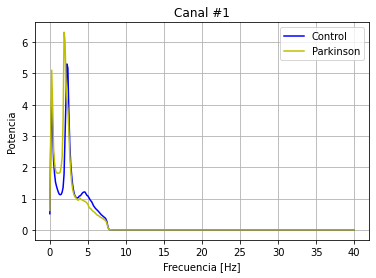

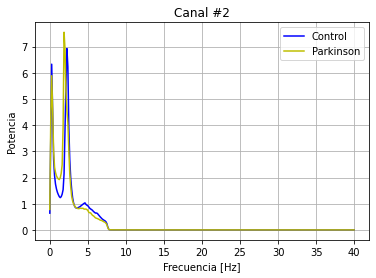

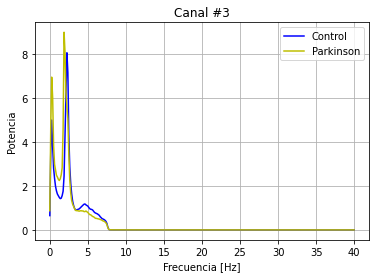

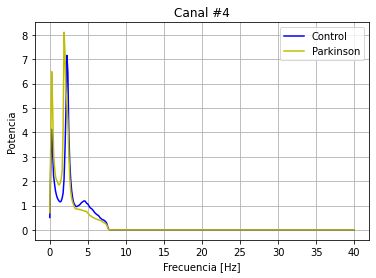

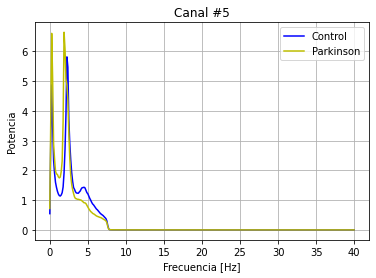

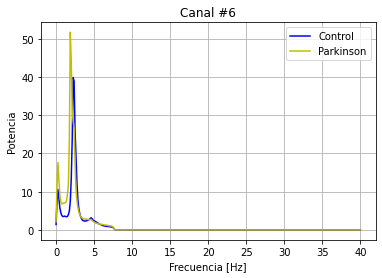

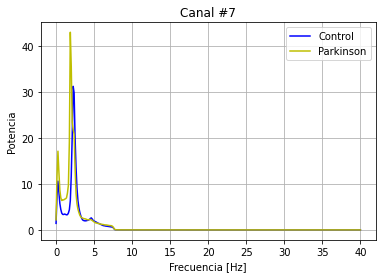

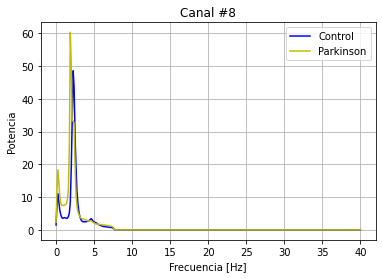

In [ ]:
def curva_canal(data_set_c, data_set_p):
  '''
  Esta funcion recive 2 grupos de datos y genera gráficos de espectro promedio
  comparando cada canal entre los dos grupos en un subplot por canal
  '''
  archivo_long= sio.loadmat(archivos_g1[1])  #Cargamos un sujeto con el fin de tener acceso a la longitud de sus dimensiones
  control1_long = archivo1['data']

  def espectro(canal):
    ''' Se calcula el espectro frecuencial para un canal'''
    senal_completa = canal.flatten('F') #Reducimos la dimension del canal para obtener una senal continua
    num_puntos_por_segundo = 250;  # Frecuencia de muestreo
    nperseg = 2000;  #Tamano de ventana
    noverlap = int(nperseg/2);  #Solapamiento de ventana
    f, Pxx = pwelch(senal_completa, num_puntos_por_segundo, 'hanning', nperseg, noverlap);  #Calculamos la densidad espectral para toda la senal
    banda = Pxx[(f >= 0) & (f <= 40)];  #se extrae la potencia de la banda
    return banda, f[0:len(banda)]

  for j in range(control1_long.shape[0]):   #Se itera sore el numero de canales

    banda=np.zeros((321))  #Creamos matrices para almacenar y sumar el espectro por cada sujeto
    b=np.zeros((321))
    f=np.zeros((321))

    for a in range(len(archivos_g1)):  #Recorremos todos los sujetos control
      data = sio.loadmat(archivos_g1[a]);
      control1= data['data']
      b,f=espectro(control1[j]);  #usamos la funcion espectro para el canal j del sujeto a
      banda=banda+b;   #Sumamos el espectro de cada sujeto control

    bandap=np.zeros((321))   #Creamos matrices para almacenar y sumar el espectro por cada sujeto
    bp=np.zeros((321))
    fp=np.zeros((321))

    for a in range(len(archivos_g2)):   #Recorremos todos los sujetos parkinson
      data = sio.loadmat(archivos_g2[a]);
      parkinson1= data['data']
      bp,fp=espectro(parkinson1[j]);   #usamos la funcion espectro para el canal j del sujeto a
      bandap=bandap+bp;   #Sumamos el espectro de cada sujeto parkinson

    '''Se generan los gráficos de espectro promedio comparando cada canal entre los dos grupos en un subplot por canal'''
    plt.figure()
    plt.plot(f,banda/36,'b',label='Control');
    plt.plot(fp,bandap/23,'y',label='Parkinson');
    plt.legend()
    plt.xlabel('Frecuencia [Hz]');
    plt.ylabel('Potencia');
    plt.title('Canal #'+str(j+1))
    plt.grid()
    plt.show();
  return
curva_canal(archivos_g1 , archivos_g2 )

**B) Discusión de las diferencias en los grupos, para los diferentes canales, usando las gráficas obtenidas usando estadística descriptiva**

**C) Planteamiento de las hipótesis nulas y alternativas, selección del tipo de prueba (paramétrica o no paramétrica). Discutir los resultados**


 
 Prueba para canal # 1

 stat=0.876, p=0.006
La senal aparentemente no es normal
stat=0.900, p=0.019
La senal aparentemente no es normal
Se debe realizar pruebas no parametricas
stat=0.000, p=0.000
Probably different distributions

 
 Prueba para canal # 2

 stat=0.833, p=0.001
La senal aparentemente no es normal
stat=0.898, p=0.016
La senal aparentemente no es normal
Se debe realizar pruebas no parametricas
stat=0.000, p=0.000
Probably different distributions

 
 Prueba para canal # 3

 stat=0.836, p=0.001
La senal aparentemente no es normal
stat=0.909, p=0.029
La senal aparentemente no es normal
Se debe realizar pruebas no parametricas
stat=0.000, p=0.000
Probably different distributions

 
 Prueba para canal # 4

 stat=0.824, p=0.001
La senal aparentemente no es normal
stat=0.891, p=0.012
La senal aparentemente no es normal
Se debe realizar pruebas no parametricas
stat=0.000, p=0.000
Probably different distributions

 
 Prueba para canal # 5

 stat=0.880, p=0.007
La senal aparent

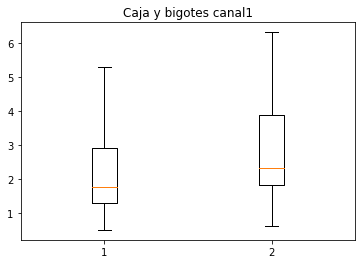

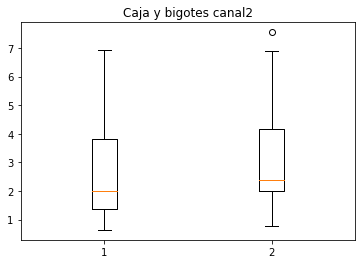

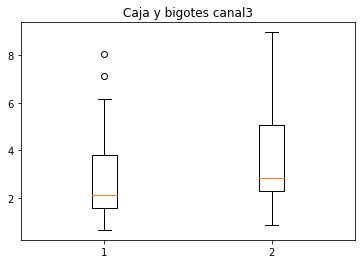

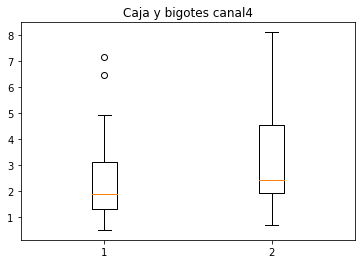

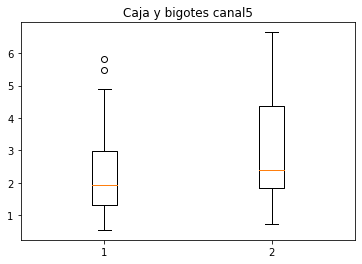

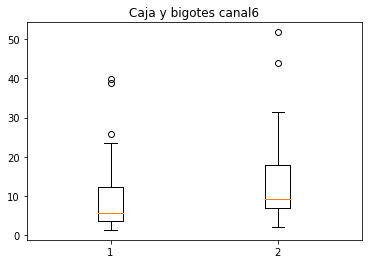

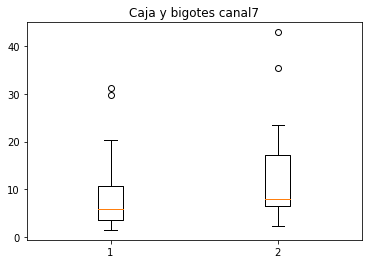

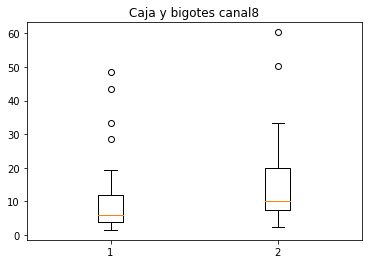

In [ ]:
def prueba_registro_delta(data_set_c, data_set_p):

#B) Grafica de caja y bigotes para valores de frecuencia en rango delta

  archivo_long= sio.loadmat(archivos_g1[1]) #Se realiza la carga del archivo
  control1_long = archivo1['data']


  def espectro(canal):#calcula el espectro para cada canal
    senal_completa = canal.flatten('F')
    num_puntos_por_segundo = 250;
    nperseg = 2000;
    noverlap = int(nperseg/2);
    f, Pxx = pwelch(senal_completa, num_puntos_por_segundo, 'hanning', nperseg, noverlap);
    banda = Pxx[(f >= 0) & (f <= 3)];#se extrae la potencia de la banda
    return banda, f[0:len(banda)]

  for j in range(control1_long.shape[0]):

    banda=np.zeros((25))#matriz con dimension de la banda de frecuencias
    b=np.zeros((25))
    f=np.zeros((25))

    for a in range(len(archivos_g1)):#recorre los sujetos de control
      data = sio.loadmat(archivos_g1[a]);
      control1= data['data']
      b,f=espectro(control1[j]);
      banda=banda+b;#se suma el espectro de cada señal control

    bandap=np.zeros((25))#matriz con dimension de la banda de frecuencias
    bp=np.zeros((25))
    fp=np.zeros((25))

    for a in range(len(archivos_g2)):#recorre los sujetos parkinson
      data = sio.loadmat(archivos_g2[a]);
      parkinson1= data['data']
      bp,fp=espectro(parkinson1[j]);
      bandap=bandap+bp;#se suma el espectro de cada señal parkinson


    plt.figure()
    plt.title('Caja y bigotes canal'+str(j+1))
    data = [(banda/36),(bandap/23)]
    plt.boxplot(data)

##C) Prueba de hipotesis
#Evaluamos que tipo de pruebas se pueden aplicar
    from scipy.stats import shapiro

    print('\n \n Prueba para canal #', j+1)
    data1 = np.squeeze(banda/36)
    stat, p = shapiro(data1)
    print('\n stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:
      print('La senal es aparentemente normal')
    else:
      print('La senal aparentemente no es normal')

    data1 = np.squeeze(bandap/23)
    stat, p1 = shapiro(data1)
    print('stat=%.3f, p=%.3f' % (stat, p1))
    if p1 > 0.05:
      print('La senal es aparentemente normal')
    else:
      print('La senal aparentemente no es normal')


    if p1 > 0.05 and p > 0.05:
      print('Se puede realizar pruebas parametricas')
    else:
      print('Se debe realizar pruebas no parametricas')

## Pruebas no parametricas segun lo encontrado en la prueba de hipotesis

    from scipy.stats import wilcoxon

    data1 = np.squeeze(banda/36)
    data2 = np.squeeze(banda/23)
    stat, p = wilcoxon(data1, data2)
    print('stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:
      print('Probably the same distribution')
    else:
      print('Probably different distributions')
  return


prueba_registro_delta(archivos_g1 , archivos_g2 )

**Para un rango de frecuencias de theta**


 
 Prueba para canal # 1

 stat=0.935, p=0.031
La senal aparentemente no es normal
stat=0.949, p=0.092
La senal es aparentemente normal
Se debe realizar pruebas no parametricas
stat=0.000, p=0.000
Probably different distributions

 
 Prueba para canal # 2

 stat=0.954, p=0.130
La senal es aparentemente normal
stat=0.941, p=0.051
La senal es aparentemente normal
Se puede realizar pruebas parametricas
stat=0.000, p=0.000
Probably different distributions

 
 Prueba para canal # 3

 stat=0.954, p=0.127
La senal es aparentemente normal
stat=0.953, p=0.119
La senal es aparentemente normal
Se puede realizar pruebas parametricas
stat=0.000, p=0.000
Probably different distributions

 
 Prueba para canal # 4

 stat=0.931, p=0.024
La senal aparentemente no es normal
stat=0.958, p=0.178
La senal es aparentemente normal
Se debe realizar pruebas no parametricas
stat=0.000, p=0.000
Probably different distributions

 
 Prueba para canal # 5

 stat=0.921, p=0.012
La senal aparentemente no es normal
st

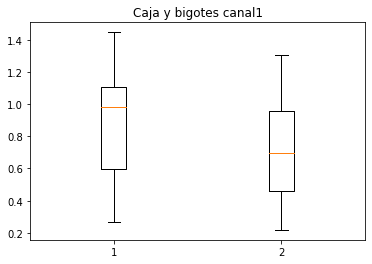

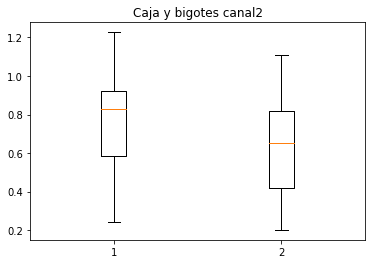

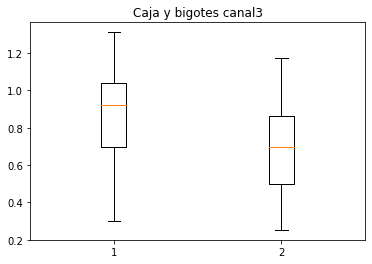

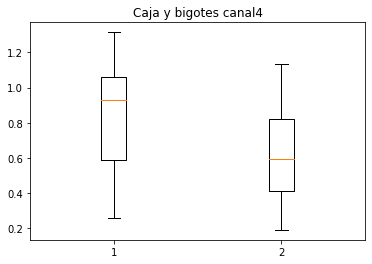

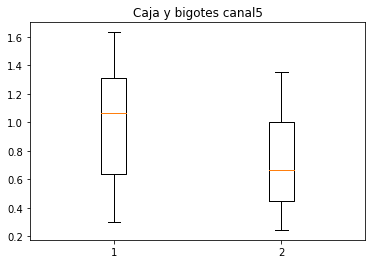

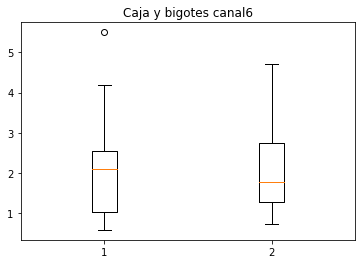

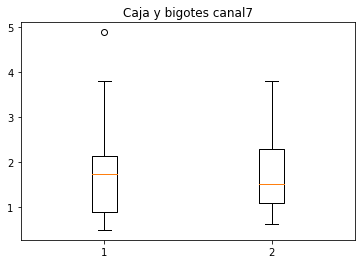

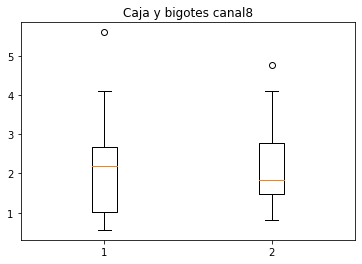

In [ ]:
def prueba_registro_theta(data_set_c, data_set_p):

#B) Grafica de caja y bigotes para valores de frecuencia en rango theta
  archivo_long= sio.loadmat(archivos_g1[1]) #Se realiza la carga del archivo
  control1_long = archivo1['data']


  def espectro(canal):#calcula el espectro para cada canal
    senal_completa = canal.flatten('F')
    num_puntos_por_segundo = 250;
    nperseg = 2000;
    noverlap = int(nperseg/2);
    f, Pxx = pwelch(senal_completa, num_puntos_por_segundo, 'hanning', nperseg, noverlap);
    banda = Pxx[(f >= 3) & (f <= 7.5)]; #se extrae la potencia de la banda
    return banda, f[0:len(banda)]

  for j in range(control1_long.shape[0]):

    banda=np.zeros((37))#matriz con dimension de la banda de frecuencias
    b=np.zeros((37))
    f=np.zeros((37))

    for a in range(len(archivos_g1)):#recorre los sujetos control
      data = sio.loadmat(archivos_g1[a]);
      control1= data['data']
      b,f=espectro(control1[j]);
      banda=banda+b;#se suma el espectro de cada señal control

    bandap=np.zeros((37))#matriz con dimension de la banda de frecuencias
    bp=np.zeros((37))
    fp=np.zeros((37))

    for a in range(len(archivos_g2)):#recorre los sujetos parkinson
      data = sio.loadmat(archivos_g2[a]);
      parkinson1= data['data']
      bp,fp=espectro(parkinson1[j]);
      bandap=bandap+bp;#se suma el espectro de cada señal parkinson


    plt.figure()
    plt.title('Caja y bigotes canal'+str(j+1))
    data = [(banda/36),(bandap/23)]
    plt.boxplot(data)

##C) Prueba de hipotesis
#Evaluamos que tipo de pruebas se pueden aplicar
    from scipy.stats import shapiro

    print('\n \n Prueba para canal #', j+1)
    data1 = np.squeeze(banda/36)
    stat, p = shapiro(data1)
    print('\n stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:
      print('La senal es aparentemente normal')
    else:
      print('La senal aparentemente no es normal')

    data1 = np.squeeze(bandap/23)
    stat, p1 = shapiro(data1)
    print('stat=%.3f, p=%.3f' % (stat, p1))
    if p1 > 0.05:
      print('La senal es aparentemente normal')
    else:
      print('La senal aparentemente no es normal')


    if p1 > 0.05 and p > 0.05:
      print('Se puede realizar pruebas parametricas')
    else:
      print('Se debe realizar pruebas no parametricas')

## Pruebas no parametricas segun lo encontrado en la prueba de hipotesis

    from scipy.stats import wilcoxon

    data1 = np.squeeze(banda/36)
    data2 = np.squeeze(banda/23)
    stat, p = wilcoxon(data1, data2)
    print('stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:
      print('Probably the same distribution')
    else:
      print('Probably different distributions')
  return


prueba_registro_theta(archivos_g1 , archivos_g2 )

**C) Evaluar si hay relación entre los valores de (alfa1 + alfa2)/theta con la entropía de permutación en los diferentes canales**





**Entropía de permutación, proyecto 1**

In [ ]:
def Entropia_de_Permutacion (EEG):
  '''
  Esta funcion recibe un vector y retorna un flotante
  Usando D=3 y Tau=1
  '''
  s = np.array(EEG)     # Señal
  tamano = s.shape    # Tamaño de la señal
  indices = range(tamano[0]-1)     # Vector de indices
  matriz = [0,0,0]    # fila de ceros de tamaño 3x1
  for v in indices:     # Este ciclo se utiliza para la partición del espacio de estado, lo cual no puede hacerse con numpy
    vfila = [s[v-1],s[v],s[v+1]]
    matriz = np.vstack([matriz,vfila])    # Concatena cada fila y organiza una matriz
  matriz = matriz[2:,:]     # Recorta las dos primeras filas, pues no son utiles
  ncol = tamano[0]-2    # Numero de columnas de la matriz transpuesta
  pi1=0; pi2=0; pi3=0; pi4=0; pi5=0; pi6=0    # Inicialización de las permutaciones
  for fila in matriz:     # Este ciclo cuenta los Patrones ordinales, que no pueden hacerse con numpy
    if fila[0]<fila[1]<fila[2]:
      pi1 += 1
    if fila[0]<fila[2] and fila[1]>fila[2]:
      pi2 += 1
    if fila[1]<fila[0] and fila[0]<fila[2]:
      pi3 += 1
    if fila[1]>fila[0] and fila[0]>fila[2]:
      pi4 += 1
    if fila[1]<fila[2] and fila[0]>fila[2]:
      pi5 += 1
    if fila[1]<fila[0] and fila[2]<fila[1]:
      pi6 += 1
  pis = np.array([pi1,pi2,pi3,pi4,pi5,pi6])     # Vector de los numeros de incidentes
  PisMay0 = pis[pis>0]/ncol     # Frecuancias relativas de los pis mayores que 0
  PE = np.dot(np.log2(PisMay0),-PisMay0)    # Entropía de permutación
  #print('La entropía de permuntación es: ' + str(PE))
  #print('La entropía de permutación normalizada es: ' + str(0.386852*PE))
  return float(PE)

In [ ]:
#se crea la matriz grupal sujetos x canales
entropia_g1 = np.zeros((len(archivos_g1),control1.shape[0]))
contador = 0

#por cada archivo de G1 se hace el analisis espectral
for archivo in archivos_g1:
  #se trabaja este en la misma carpeta de los datos para que pueda funcionar
  archivo1 = sio.loadmat(archivos_g1[contador]);
  control1 = archivo1['data'];

  #%% CONTINUA
  sensores = control1.shape[0];
  puntos = control1.shape[1];
  epocas = control1.shape[2];

  for s in range(sensores):
    h = 0
    for e in range(epocas):
      h = h + Entropia_de_Permutacion(control1[s,:,e])
    h = h/epocas #promedio
    entropia_g1[contador,s] = h #se guarda la entropia del sujeto en el sensor s

  contador += 1

In [ ]:
#se crea la matriz grupal sujetos x canales
entropia_g2 = np.zeros((len(archivos_g2),parkinson1.shape[0]))
contador = 0

#por cada archivo de G1 se hace el analisis espectral
for archivo in archivos_g2:
  #se trabaja este en la misma carpeta de los datos para que pueda funcionar
  archivo2 = sio.loadmat(archivos_g2[contador]);
  parkinson1 = archivo2['data'];

  #%% CONTINUA
  sensores = parkinson1.shape[0];
  puntos = parkinson1.shape[1];
  epocas = parkinson1.shape[2];

  for s in range(sensores):
    h = 0
    for e in range(epocas):
      h = h + Entropia_de_Permutacion(parkinson1[s,:,e])
    h = h/epocas #promedio
    entropia_g2[contador,s] = h #se guarda la entropia del sujeto en el sensor s

  contador += 1

In [ ]:
relacion_control = []
relacion_parkinson =[]
h=0
pos = [1,3,5,7,9,11,13,15]
for i in pos:
  cont = tabla.iloc[0:36,i] + h
  park =tabla.iloc[36:59,i] + h
  relacion_control.append(cont)
  relacion_parkinson.append(park)
  h = h+h

In [ ]:
from scipy.stats import pearsonr

for i in range(8):
  data1 = np.squeeze(entropia_g1[:,i])
  data2 = np.squeeze(relacion_control[i])
  stat,p = pearsonr(data1 , data2)
  print('stat=%.5f, p=%.5f' % (stat, p))
  if p > 0.05:
	  print('Probablemente independiente los canales '+ str(i+1))
  else:
	  print('Probablemente dependiente los canales '+ str(i+1))
  i=i+1



stat=-0.60325, p=0.00010
Probablemente dependiente los canales 1
stat=-0.73284, p=0.00000
Probablemente dependiente los canales 2
stat=-0.67188, p=0.00001
Probablemente dependiente los canales 3
stat=-0.59095, p=0.00015
Probablemente dependiente los canales 4
stat=-0.09677, p=0.57449
Probablemente independiente los canales 5
stat=-0.54586, p=0.00057
Probablemente dependiente los canales 6
stat=-0.50083, p=0.00186
Probablemente dependiente los canales 7
stat=-0.54988, p=0.00051
Probablemente dependiente los canales 8


In [ ]:
from scipy.stats import pearsonr

for i in range(8):
  data1 = np.squeeze(entropia_g2[:,i])
  data2 = np.squeeze(relacion_parkinson[i])
  stat,p = pearsonr(data1 , data2)
  print('stat=%.5f, p=%.5f' % (stat, p))
  if p > 0.05:
	  print('Probablemente independiente los canales '+ str(i+1))
  else:
	  print('Probablemente dependiente los canales '+ str(i+1))
  i=i+1


stat=-0.81565, p=0.00000
Probablemente dependiente los canales 1
stat=-0.74553, p=0.00004
Probablemente dependiente los canales 2
stat=-0.72908, p=0.00008
Probablemente dependiente los canales 3
stat=-0.77578, p=0.00001
Probablemente dependiente los canales 4
stat=-0.72741, p=0.00008
Probablemente dependiente los canales 5
stat=-0.84323, p=0.00000
Probablemente dependiente los canales 6
stat=-0.75616, p=0.00003
Probablemente dependiente los canales 7
stat=-0.73070, p=0.00008
Probablemente dependiente los canales 8
